<a href="https://colab.research.google.com/github/eyounge-lab/sentiment_analysis/blob/main/younge-NLP-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/Azubi-Africa/post-bap-P5.git

Cloning into 'post-bap-P5'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 203 (delta 108), reused 197 (delta 106), pack-reused 0
Receiving objects: 100% (203/203), 856.35 KiB | 21.41 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.0 MB/s eta 0:00:00


In [3]:
!pip install datasets transformers huggingface_hub


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch
torch.cuda.is_available()


True

In [5]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from transformers import pipeline
import torch
import os
import torch.nn.functional as F
from transformers import AdamW
from datasets import Dataset

In [6]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [7]:
import pandas as pd
df = pd.read_csv('/content/post-bap-P5/zindi_challenge/data/Train.csv')

In [8]:
# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

#Data Exploration

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'label score')

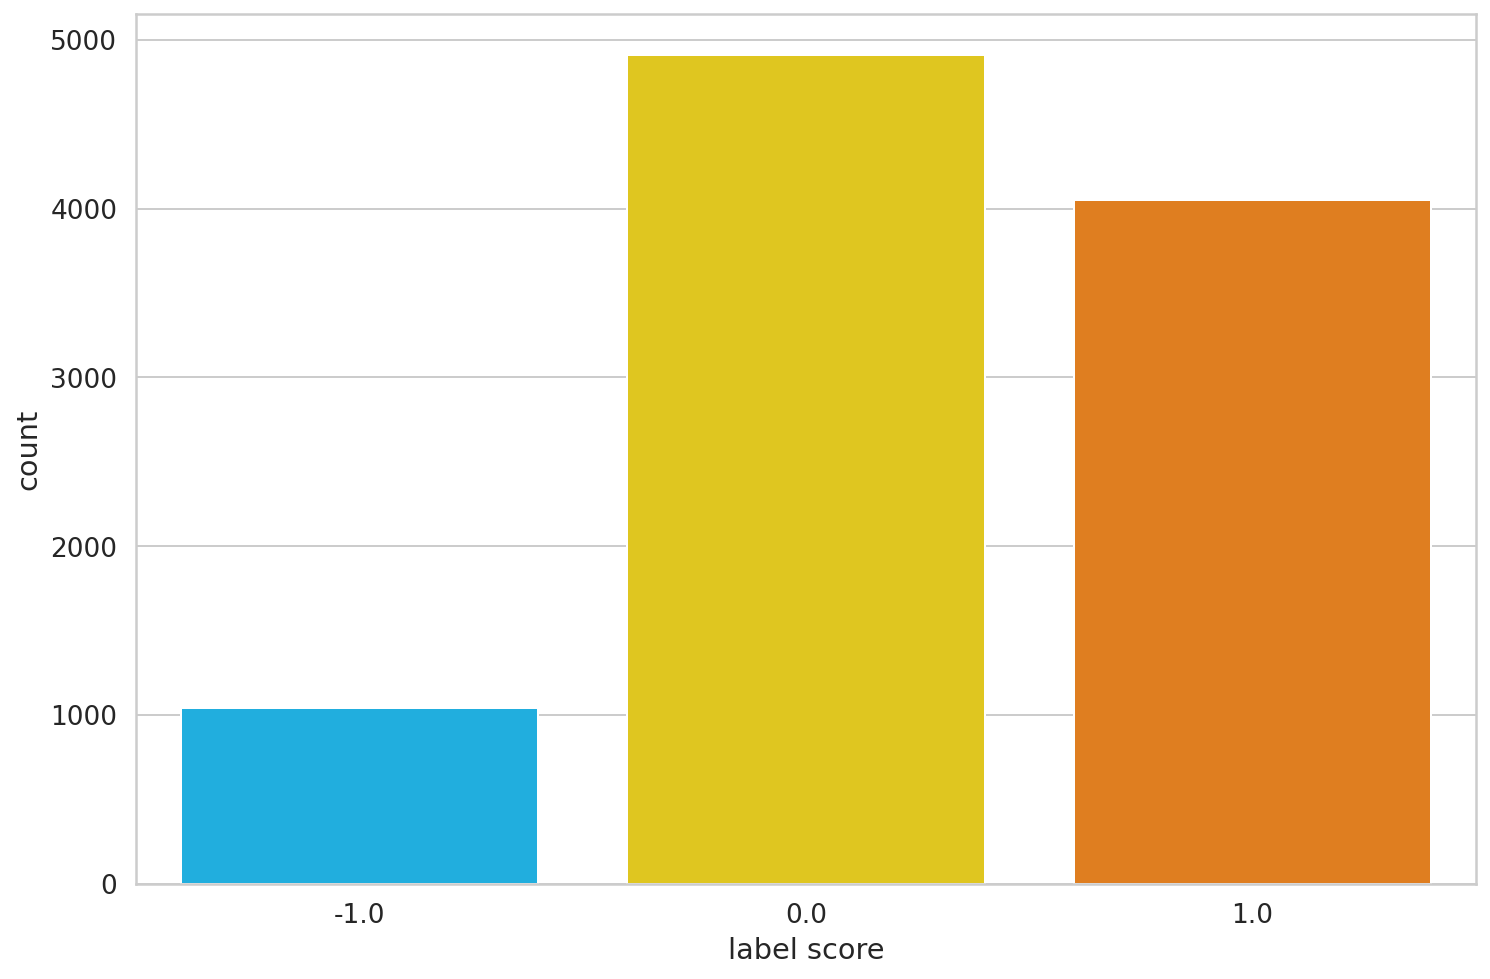

In [9]:
# CHECKING SCORE IN  TWEET LABELS FOR COVID VACCINATION 
sns.countplot(df.label)
plt.xlabel('label score')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'agreement score')

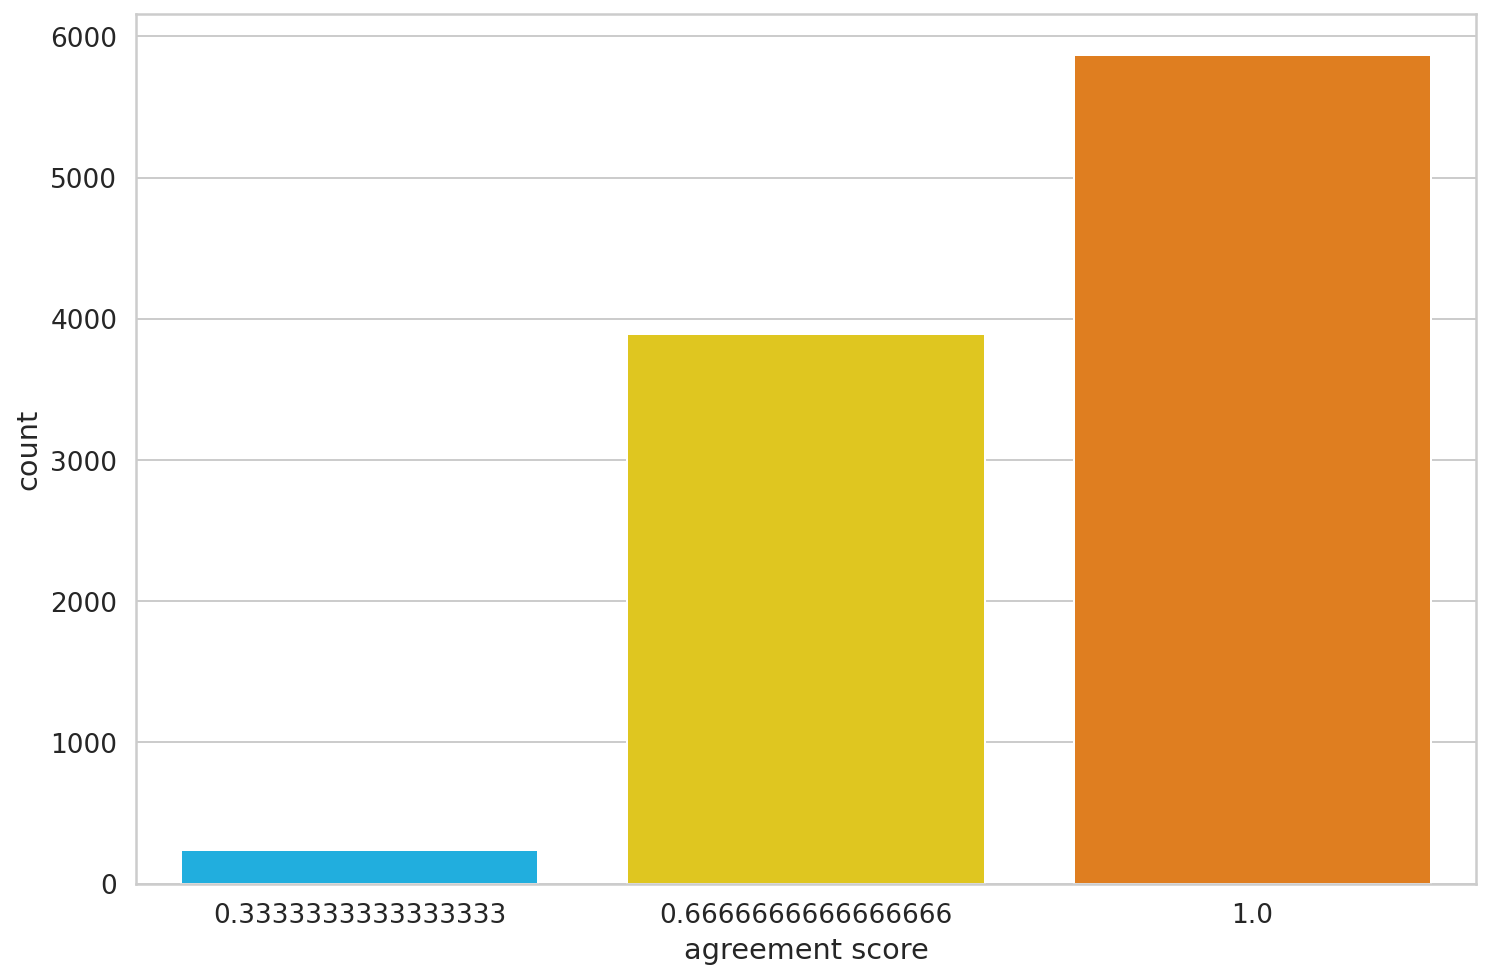

In [10]:
# CHECKING SCORE IN TWEET AGREEMENT ON  COVID VACCINATION
sns.countplot(df.agreement)
plt.xlabel('agreement score')

In [11]:
def to_sentiment(rating):
  rating = int(rating)
  if rating < 0:
    return 0
  elif rating == 0:
    return 1
  else:
    return 2
df['sentiment'] = df.label.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


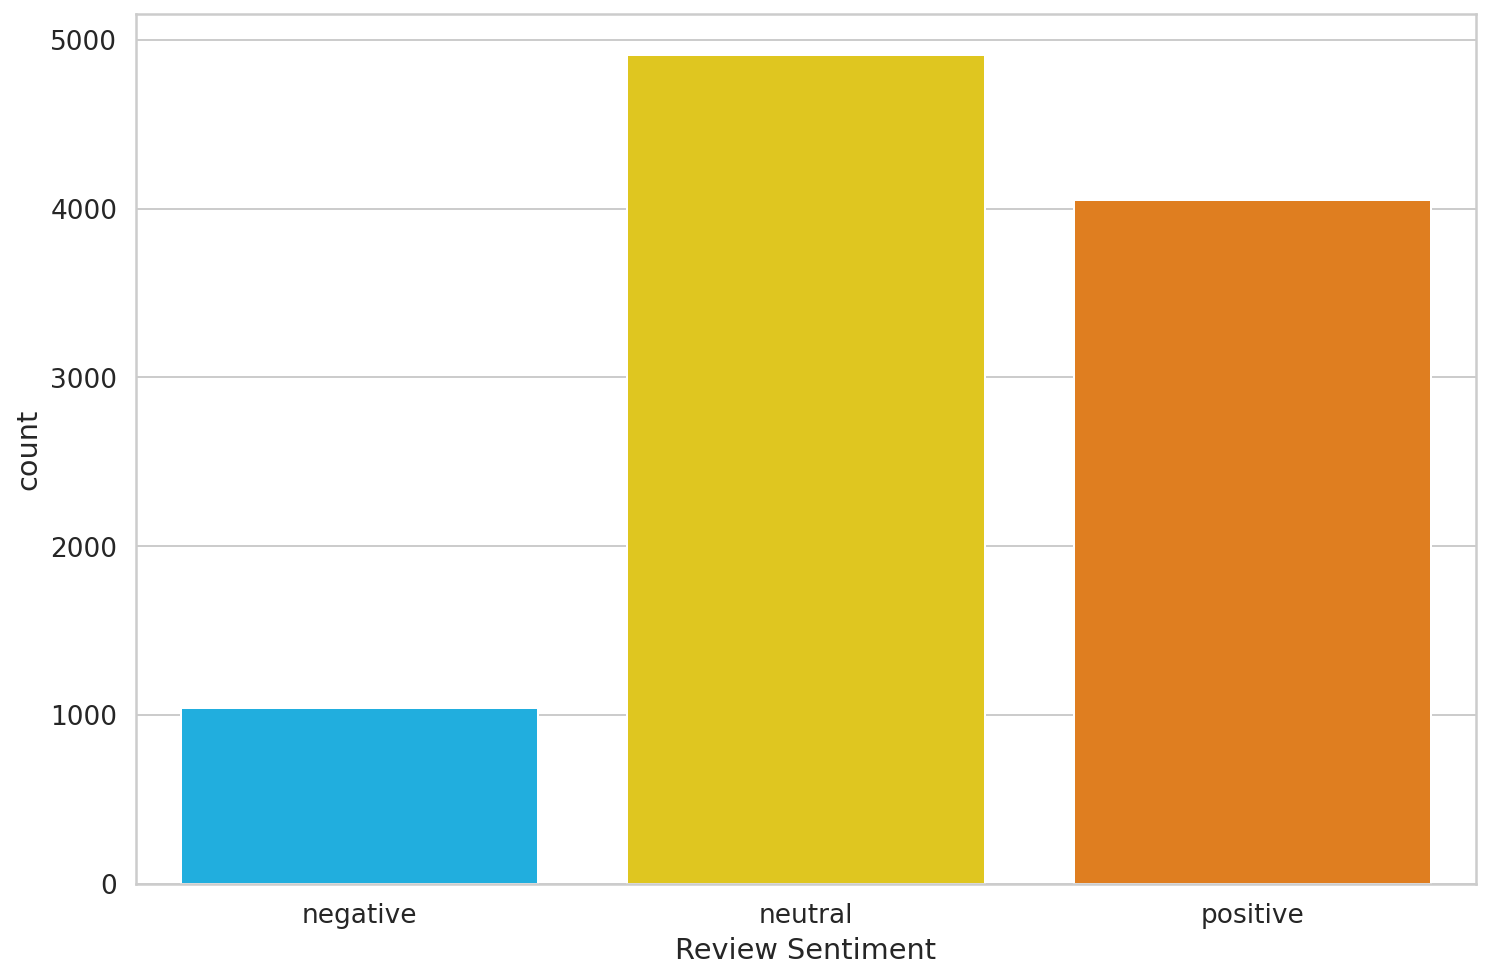

In [12]:
# EXPECTED SENTIMENT INDICES AS POSITIVE, NEGATIVE AND NEUTRAL
ax = sns.countplot(df.sentiment)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names);

In [13]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [14]:
# Save splitted dataset
train.to_csv('train_subset.csv')
eval.to_csv('eval_subset.csv')

In [15]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': '/content/train_subset.csv','eval': '/content/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-68c741b23c26ed8b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

#using distibert model

In [16]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/7999 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

###To speed up training, let's use a data_collator to convert your training samples to PyTorch tensors and concatenate them with the correct amount of padding

In [91]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [95]:
from transformers import TrainingArguments

# Configure the trianing parameters like `num_train_epochs`: 
# the number of time the model will repeat the training loop over the dataset
 
training_args = TrainingArguments(
   output_dir="./younge-finetune-sentiment-analysis-p",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=5,
   weight_decay=0.01,
   metric_for_best_model='loss', 
   greater_is_better=False,
   save_strategy="epoch",
   push_to_hub=True,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [96]:
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/

## Splitting dataset into train and validation samples

In [98]:
train_dataset = dataset['train'].shuffle(seed=10).select([i for i in list(range(4000))]) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10).select([i for i in list(range(500))])



In [102]:
from huggingface_hub import notebook_login
notebook_login()


Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Using the tranformers trainer to train the model

In [103]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

# Launch the learning process: training 
trainer.train()


/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(


HfHubHTTPError: ignored

In [71]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [72]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [73]:
# Launch the final evaluation 
eval_results = trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentiment, Unnamed: 0. If sentiment, Unnamed: 0 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


In [74]:
import glob
import math

path = "/content/younge-finetune-sentiment-analysis-p/model"

for modelpath in glob.iglob(path):
  print('Model: ', modelpath)
  tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast = False, do_lower_case=True)
  model = AutoModelForSequenceClassification.from_pretrained(modelpath)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)
  
  eval_results = trainer.evaluate()

  print('Evaluation results: ', eval_results)
  print(f"Perplexity: {math.exp(eval_results['eval_loss']):.3f}")
  print('----------------\n')

###saving the model

In [75]:
custome_model = trainer.save_model("/content/younge-finetune-sentiment-analysis-p/to/content/results")
custom_tokenizer = tokenizer.save_pretrained("/content/younge-finetune-sentiment-analysis-p/to/content/results")

Saving model checkpoint to /content/younge-finetune-sentiment-analysis-p/to/content/results
Configuration saved in /content/younge-finetune-sentiment-analysis-p/to/content/results/config.json
Model weights saved in /content/younge-finetune-sentiment-analysis-p/to/content/results/pytorch_model.bin
tokenizer config file saved in /content/younge-finetune-sentiment-analysis-p/to/content/results/tokenizer_config.json
Special tokens file saved in /content/younge-finetune-sentiment-analysis-p/to/content/results/special_tokens_map.json


##Getting the model

In [77]:
os.getcwd()

'/content'

# Evaluating model on test dataset

In [78]:
import pandas as pd
df = pd.read_csv('/content/post-bap-P5/zindi_challenge/data/Test.csv')

In [79]:
df

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."
...,...,...
5172,ZXVVNC5O,jenny mccarthy is on new years rockin eve. wha...
5173,ZYIANVI8,Measles reported in Clark Co. for 1st time sin...
5174,ZYITEHAH,<user> issues alert regarding Measles in TX. K...
5175,ZZ3BMBTG,I can't believe people don't vaccinate their k...


In [80]:
# from transformers import pipeline
 
# sentiment_model = pipeline(task= 'sentiment-analysis', model="/content/younge-finetune-sentiment-analysis-p/checkpoint-500")
# sentiment_model(df['safe_text'].values[0])


In [81]:
# trainer.save_model("path/to/content/results")
# tokenizer.save_pretrained("path/to/content/results")

In [82]:
# # RMSE scoring on our validation set:
# from sklearn.metrics import mean_squared_error as skmse
# skmse(eval_dataset['label'], model_outputs)**0.5

In [83]:
# # Saving Predictions
# sub = pd.DataFrame({
#     'tweet_id':test['tweet_id'],
#     'label':model.predict(test['safe_text'].values)[0]
# })
# sub.to_csv('transfomer_1.csv', index=False)

##*Publish your custom model on Hugging Face!* 
If you trained your model on a personal dataset, or a particular dataset you created yourself, your model could probably be useful to someone else. Upload it to your Hugging Face account with just a few lines of code!

First of all create a personal account on Hugging Face, and then run the following commands.

In [ ]:

!pip install huggingface_hub

#login hugging face
from huggingface_hub import notebook_login
notebook_login()


#push your model
model = AutoModelForSequenceClassification.from_pretrained("/content/younge-finetune-sentiment-analysis-p/model")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = "/content/younge-finetune-sentiment-analysis-p/model")

model.push_to_hub("younge-distilbert-sent-analysis-model")
tokenizer.push_to_hub("younge-distilbert-sent-analysis-model")

# Testing the fintuned model

In [84]:
# # Preprocess text (username and link placeholders)
# def preprocess(text):
#     new_text = []
#     for t in text.split(" "):
#         t = '@user' if t.startswith('@') and len(t) > 1 else t
#         t = 'http' if t.startswith('http') else t
#         new_text.append(t)
#     return " ".join(new_text)
# MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# config = AutoConfig.from_pretrained(MODEL)

In [85]:
# # Python Transformers
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [86]:
# from scipy.special import softmax
# # model.save_pretrained(MODEL)
# text = 'Vaccination may cause illness'
# text = preprocess(text)
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)
# scores = output[0][0].detach().numpy()
# scores = softmax(scores)

In [87]:
# # Print labels and scores
# ranking = np.argsort(scores)
# ranking = ranking[::-1]
# for i in range(scores.shape[0]):
#     l = config.id2label[ranking[i]]
#     s = scores[ranking[i]]
#     print(f"{i+1}) {l} {np.round(float(s), 4)}")

In [88]:
# from transformers import pipeline
# sentiment_task = pipeline(task = 'sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment-latest',
#                           tokenizer='cardiffnlp/twitter-roberta-base-sentiment-latest')
# sentiment_task(text)

#Gradio App

In [89]:
# !pip install gradio

In [90]:
# ## Requirements
# model_path = f"finiteautomata/bertweet-base-sentiment-analysis"
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# config = AutoConfig.from_pretrained(model_path)
# model = AutoModelForSequenceClassification.from_pretrained(model_path)

# # Preprocess text (username and link placeholders)
# def preprocess(Input_text):
#     new_text = []
#     for t in text.split(" "):
#         t = '@user' if t.startswith('@') and len(t) > 1 else t
#         t = 'http' if t.startswith('http') else t
#         new_text.append(t)
#     return " ".join(new_text)

# def sentiment_analysis(Input_text):
#     Message = preprocess(Input_text)

#     # PyTorch-based models
#     encoded_input = tokenizer(Message, return_tensors='pt')
#     output = model(**encoded_input)
#     scores_ = output[0][0].detach().numpy()
#     scores_ = softmax(scores_)
    
#     # Format output dict of scores
#     labels = ['Negative', 'Neutral', 'Positive']
#     scores = {l:float(s) for (l,s) in zip(labels, scores_) }
    
#     return scores

# demo = gr.Interface(
#     fn=sentiment_analysis, 
#     inputs=gr.Textbox(placeholder="Write your tweet here..."), 
#     outputs="label", 
#     interpretation="default",
#     Caution =[["COVID-19 is real!"]])

# demo.launch()

#Using bert model

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
! git clone https://github.com/Azubi-Africa/post-bap-P5.git

Cloning into 'post-bap-P5'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 203 (delta 108), reused 197 (delta 106), pack-reused 0
Receiving objects: 100% (203/203), 856.35 KiB | 21.41 MiB/s, done.
Resolving deltas: 100% (108/108), done.


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.0 MB/s eta 0:00:00


In [ ]:
!pip install datasets transformers huggingface_hub


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torch
torch.cuda.is_available()


True

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from transformers import pipeline
import torch
import os
import torch.nn.functional as F
from transformers import AdamW
from datasets import Dataset

In [ ]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import pandas as pd
df = pd.read_csv('/content/post-bap-P5/zindi_challenge/data/Train.csv')

In [ ]:
# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]

#Data Exploration

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'label score')

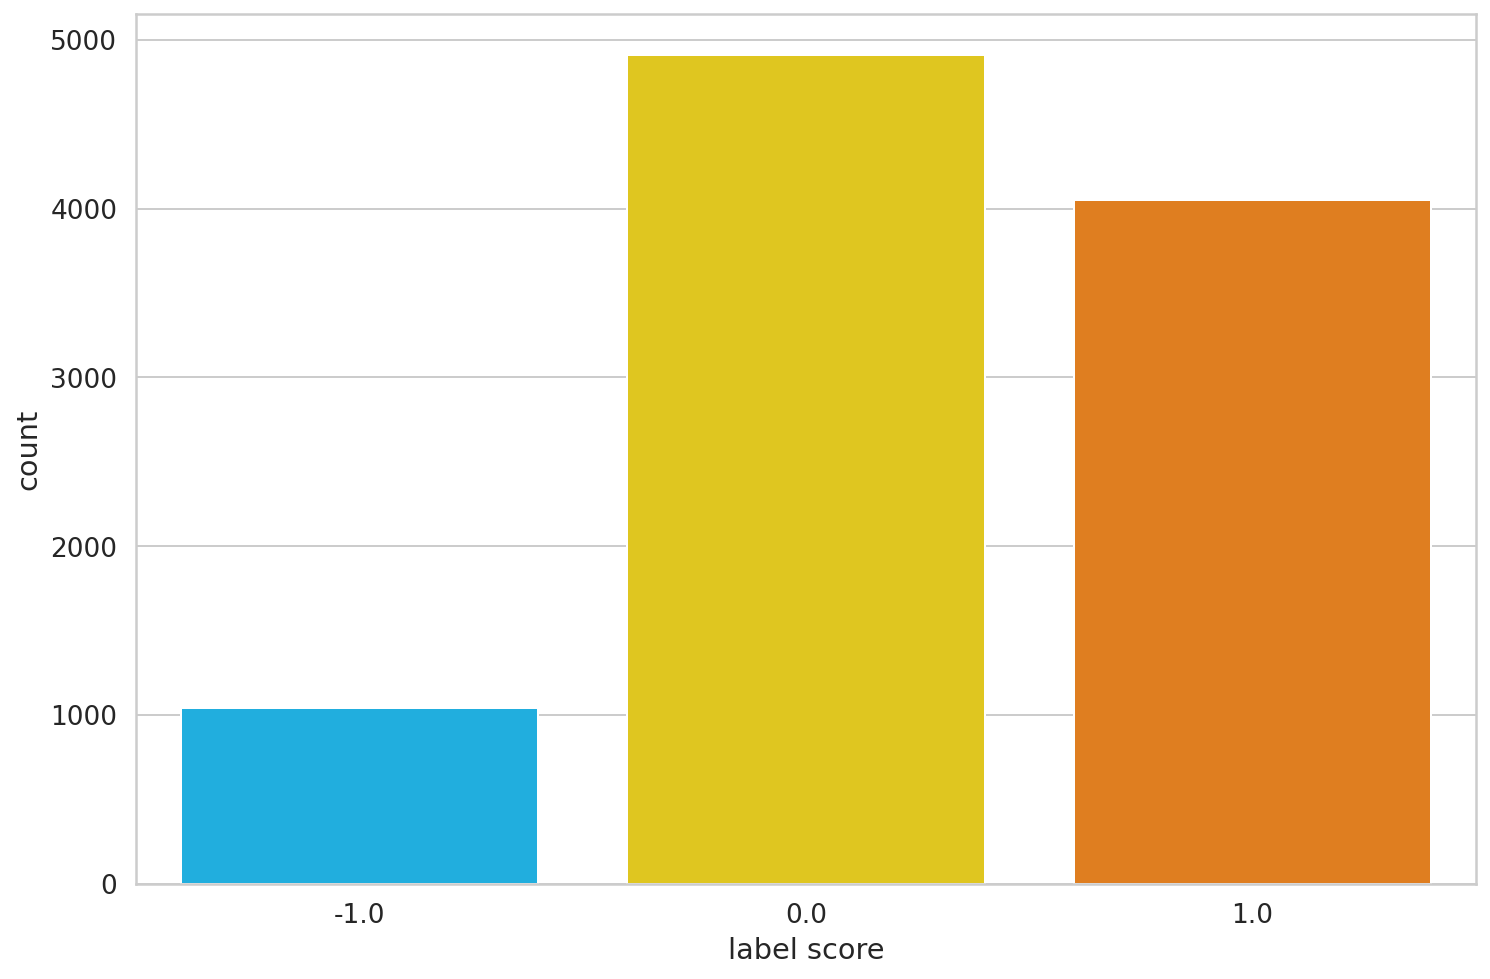

In [ ]:
# CHECKING SCORE IN  TWEET LABELS FOR COVID VACCINATION 
sns.countplot(df.label)
plt.xlabel('label score')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'agreement score')

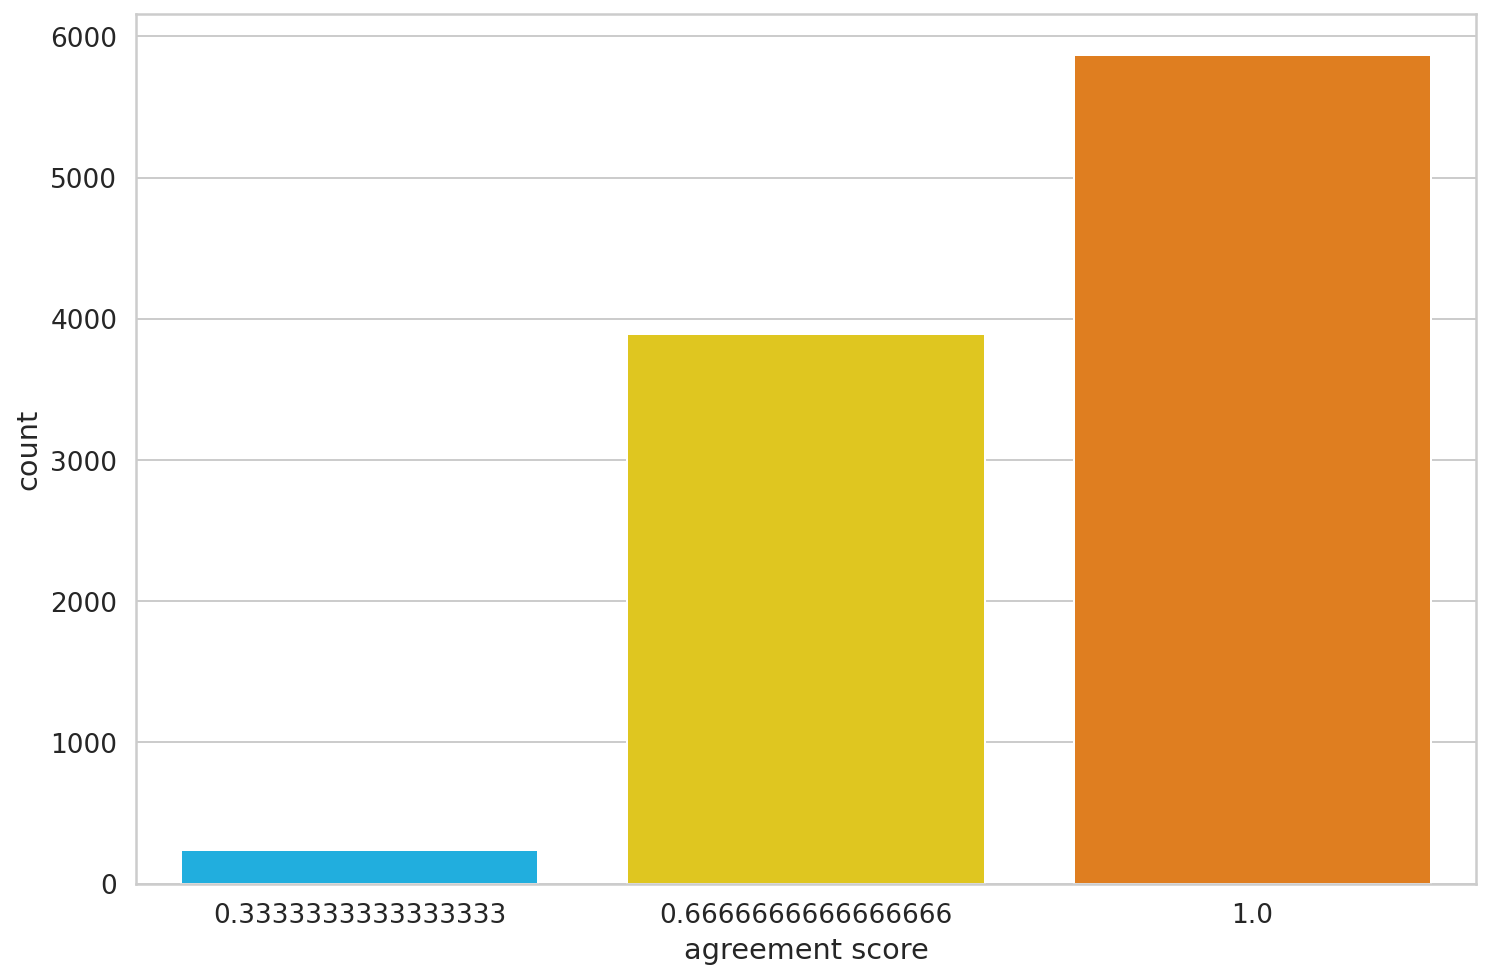

In [ ]:
# CHECKING SCORE IN TWEET AGREEMENT ON  COVID VACCINATION
sns.countplot(df.agreement)
plt.xlabel('agreement score')

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating < 0:
    return 0
  elif rating == 0:
    return 1
  else:
    return 2
df['sentiment'] = df.label.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


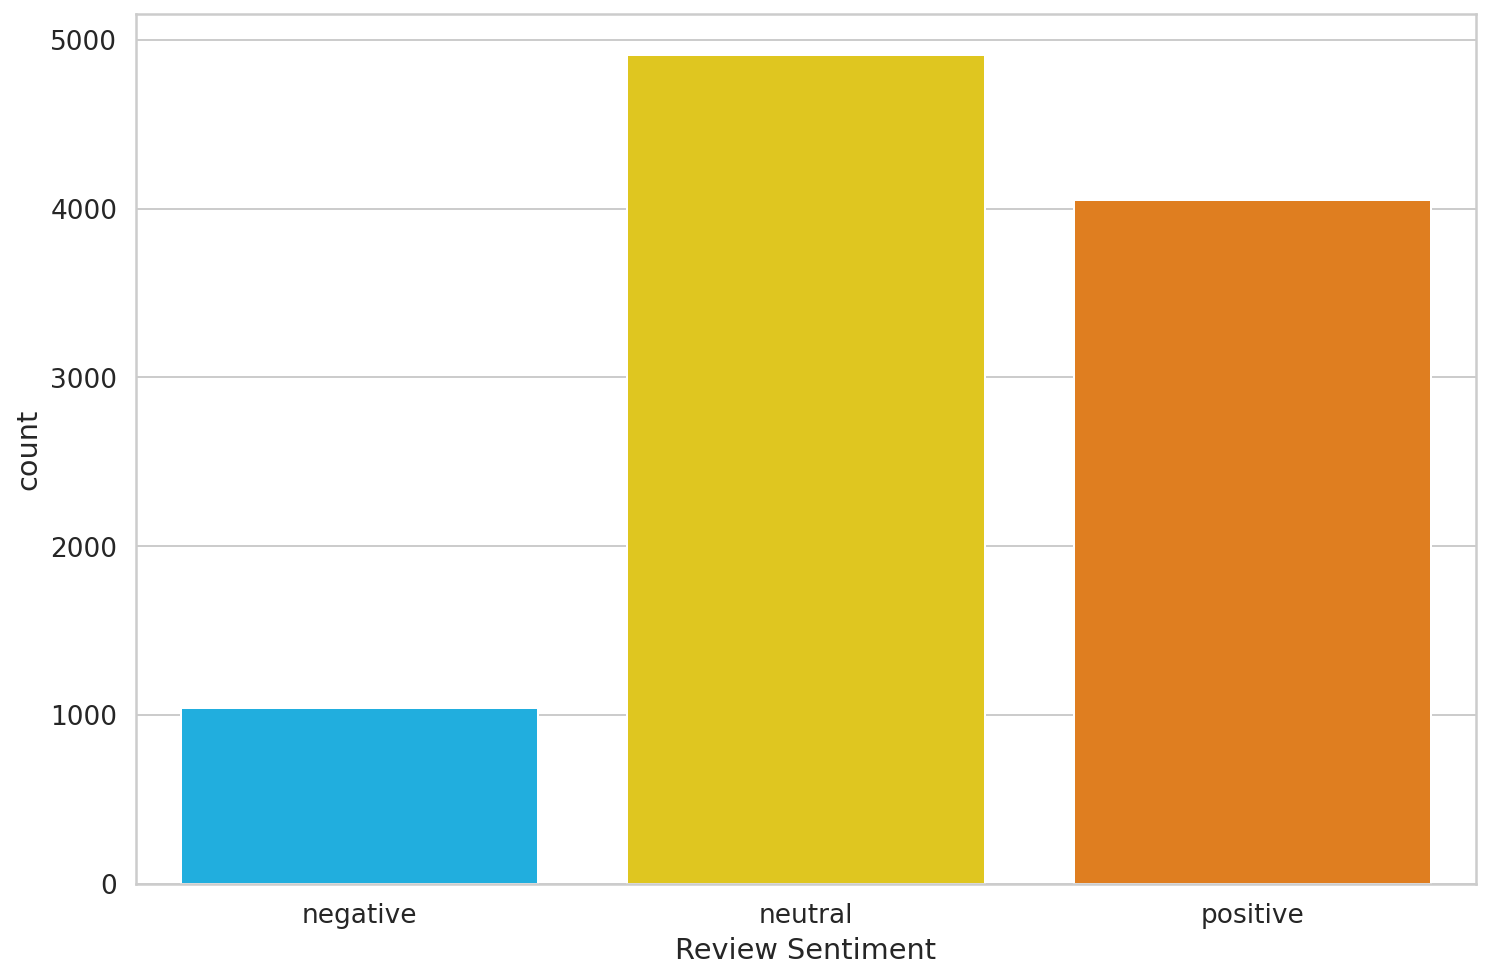

In [ ]:
# EXPECTED SENTIMENT INDICES AS POSITIVE, NEGATIVE AND NEUTRAL
ax = sns.countplot(df.sentiment)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names);

In [ ]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [ ]:
# Save splitted dataset
train.to_csv('train_subset.csv')
eval.to_csv('eval_subset.csv')

In [ ]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': '/content/train_subset.csv','eval': '/content/eval_subset.csv'}, encoding = "ISO-8859-1")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-68c741b23c26ed8b/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

#using distibert model

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/7999 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

###To speed up training, let's use a data_collator to convert your training samples to PyTorch tensors and concatenate them with the correct amount of padding

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
from transformers import TrainingArguments

# Configure the trianing parameters like `num_train_epochs`: 
# the number of time the model will repeat the training loop over the dataset
 
training_args = TrainingArguments(
   output_dir="./younge-finetune-sentiment-analysis-p",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=5,
   weight_decay=0.01,
   metric_for_best_model='loss', 
   greater_is_better=False,
   save_strategy="epoch",
   push_to_hub=True,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/

## Splitting dataset into train and validation samples

In [ ]:
train_dataset = dataset['train'].shuffle(seed=10).select([i for i in list(range(4000))]) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10).select([i for i in list(range(500))])



In [ ]:
from huggingface_hub import notebook_login
notebook_login()


Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Using the tranformers trainer to train the model

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

# Launch the learning process: training 
trainer.train()


/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(


HfHubHTTPError: ignored

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Launch the final evaluation 
eval_results = trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentiment, Unnamed: 0. If sentiment, Unnamed: 0 are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 300
  Batch size = 16


In [ ]:
import glob
import math

path = "/content/younge-finetune-sentiment-analysis-p/model"

for modelpath in glob.iglob(path):
  print('Model: ', modelpath)
  tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast = False, do_lower_case=True)
  model = AutoModelForSequenceClassification.from_pretrained(modelpath)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)
  
  eval_results = trainer.evaluate()

  print('Evaluation results: ', eval_results)
  print(f"Perplexity: {math.exp(eval_results['eval_loss']):.3f}")
  print('----------------\n')

###saving the model

In [ ]:
custome_model = trainer.save_model("/content/younge-finetune-sentiment-analysis-p/to/content/results")
custom_tokenizer = tokenizer.save_pretrained("/content/younge-finetune-sentiment-analysis-p/to/content/results")

Saving model checkpoint to /content/younge-finetune-sentiment-analysis-p/to/content/results
Configuration saved in /content/younge-finetune-sentiment-analysis-p/to/content/results/config.json
Model weights saved in /content/younge-finetune-sentiment-analysis-p/to/content/results/pytorch_model.bin
tokenizer config file saved in /content/younge-finetune-sentiment-analysis-p/to/content/results/tokenizer_config.json
Special tokens file saved in /content/younge-finetune-sentiment-analysis-p/to/content/results/special_tokens_map.json


##Getting the model

In [ ]:
os.getcwd()

'/content'

# Evaluating model on test dataset

In [ ]:
import pandas as pd
df = pd.read_csv('/content/post-bap-P5/zindi_challenge/data/Test.csv')

In [ ]:
df

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."
...,...,...
5172,ZXVVNC5O,jenny mccarthy is on new years rockin eve. wha...
5173,ZYIANVI8,Measles reported in Clark Co. for 1st time sin...
5174,ZYITEHAH,<user> issues alert regarding Measles in TX. K...
5175,ZZ3BMBTG,I can't believe people don't vaccinate their k...


In [ ]:
# from transformers import pipeline
 
# sentiment_model = pipeline(task= 'sentiment-analysis', model="/content/younge-finetune-sentiment-analysis-p/checkpoint-500")
# sentiment_model(df['safe_text'].values[0])


In [ ]:
# trainer.save_model("path/to/content/results")
# tokenizer.save_pretrained("path/to/content/results")

In [ ]:
# # RMSE scoring on our validation set:
# from sklearn.metrics import mean_squared_error as skmse
# skmse(eval_dataset['label'], model_outputs)**0.5

In [ ]:
# # Saving Predictions
# sub = pd.DataFrame({
#     'tweet_id':test['tweet_id'],
#     'label':model.predict(test['safe_text'].values)[0]
# })
# sub.to_csv('transfomer_1.csv', index=False)

##*Publish your custom model on Hugging Face!* 
If you trained your model on a personal dataset, or a particular dataset you created yourself, your model could probably be useful to someone else. Upload it to your Hugging Face account with just a few lines of code!

First of all create a personal account on Hugging Face, and then run the following commands.

In [ ]:

!pip install huggingface_hub

#login hugging face
from huggingface_hub import notebook_login
notebook_login()


#push your model
model = AutoModelForSequenceClassification.from_pretrained("/content/younge-finetune-sentiment-analysis-p/model")
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = "/content/younge-finetune-sentiment-analysis-p/model")

model.push_to_hub("younge-distilbert-sent-analysis-model")
tokenizer.push_to_hub("younge-distilbert-sent-analysis-model")

# Testing the fintuned model

In [ ]:
# # Preprocess text (username and link placeholders)
# def preprocess(text):
#     new_text = []
#     for t in text.split(" "):
#         t = '@user' if t.startswith('@') and len(t) > 1 else t
#         t = 'http' if t.startswith('http') else t
#         new_text.append(t)
#     return " ".join(new_text)
# MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# config = AutoConfig.from_pretrained(MODEL)

In [ ]:
# # Python Transformers
# model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# from scipy.special import softmax
# # model.save_pretrained(MODEL)
# text = 'Vaccination may cause illness'
# text = preprocess(text)
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)
# scores = output[0][0].detach().numpy()
# scores = softmax(scores)

In [ ]:
# # Print labels and scores
# ranking = np.argsort(scores)
# ranking = ranking[::-1]
# for i in range(scores.shape[0]):
#     l = config.id2label[ranking[i]]
#     s = scores[ranking[i]]
#     print(f"{i+1}) {l} {np.round(float(s), 4)}")

In [ ]:
# from transformers import pipeline
# sentiment_task = pipeline(task = 'sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment-latest',
#                           tokenizer='cardiffnlp/twitter-roberta-base-sentiment-latest')
# sentiment_task(text)

#Gradio App

In [ ]:
# !pip install gradio

In [ ]:
# ## Requirements
# model_path = f"finiteautomata/bertweet-base-sentiment-analysis"
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# config = AutoConfig.from_pretrained(model_path)
# model = AutoModelForSequenceClassification.from_pretrained(model_path)

# # Preprocess text (username and link placeholders)
# def preprocess(Input_text):
#     new_text = []
#     for t in text.split(" "):
#         t = '@user' if t.startswith('@') and len(t) > 1 else t
#         t = 'http' if t.startswith('http') else t
#         new_text.append(t)
#     return " ".join(new_text)

# def sentiment_analysis(Input_text):
#     Message = preprocess(Input_text)

#     # PyTorch-based models
#     encoded_input = tokenizer(Message, return_tensors='pt')
#     output = model(**encoded_input)
#     scores_ = output[0][0].detach().numpy()
#     scores_ = softmax(scores_)
    
#     # Format output dict of scores
#     labels = ['Negative', 'Neutral', 'Positive']
#     scores = {l:float(s) for (l,s) in zip(labels, scores_) }
    
#     return scores

# demo = gr.Interface(
#     fn=sentiment_analysis, 
#     inputs=gr.Textbox(placeholder="Write your tweet here..."), 
#     outputs="label", 
#     interpretation="default",
#     Caution =[["COVID-19 is real!"]])

# demo.launch()

#Using bert model

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")